## How to Train YOLOv8 Object Detection on a Custom Dataset

In [1]:
!nvidia-smi

Fri Dec 29 08:18:55 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              42W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [3]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.2/663.2 kB 11.5 MB/s eta 0:00:00


## Install YOLOv8

In [4]:
from ultralytics import YOLO
import os
from IPython.display import display, Image
from IPython import display
from google.colab import drive
drive.mount('/content/drive')
display.clear_output()
!yolo mode=checks

Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/cfg/__init__.py", line 395, in entrypoint
    raise ValueError(f"Invalid 'mode={mode}'. Valid modes are {MODES}.\n{CLI_HELP_MSG}")
ValueError: Invalid 'mode=<module 'ultralytics.utils.checks' from '/usr/local/lib/python3.10/dist-packages/ultralytics/utils/checks.py'>'. Valid modes are ('train', 'val', 'predict', 'export', 'track', 'benchmark').

    Arguments received: ['yolo', 'mode=checks']. Ultralytics 'yolo' commands use the following syntax:

        yolo TASK MODE ARGS

        Where   TASK (optional) is one of ('detect', 'segment', 'classify', 'pose')
                MODE (required) is one of ('train', 'val', 'predict', 'export', 'track', 'benchmark')
                ARGS (optional) are any number of custom 'arg=value' pairs like 'imgsz=320' that override defaults.
                    See all ARGS at https://d

## Inference Example with Pretrained YOLOv8 Model

In [ ]:
!yolo task=detect mode=predict model=yolov8n.pt conf=0.25 source='https://media.roboflow.com/notebooks/examples/dog.jpeg'

100% 104k/104k [00:00<00:00, 64.9MB/s]
Ultralytics YOLOv8.0.5 🚀 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)
100% 6.24M/6.24M [00:00<00:00, 27.7MB/s]

Fusing layers... 
YOLOv8n summary: 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs
image 1/1 /content/dog.jpeg: 640x384 1 person, 1 car, 1 dog, 13.5ms
Speed: 0.4ms pre-process, 13.5ms inference, 16.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict


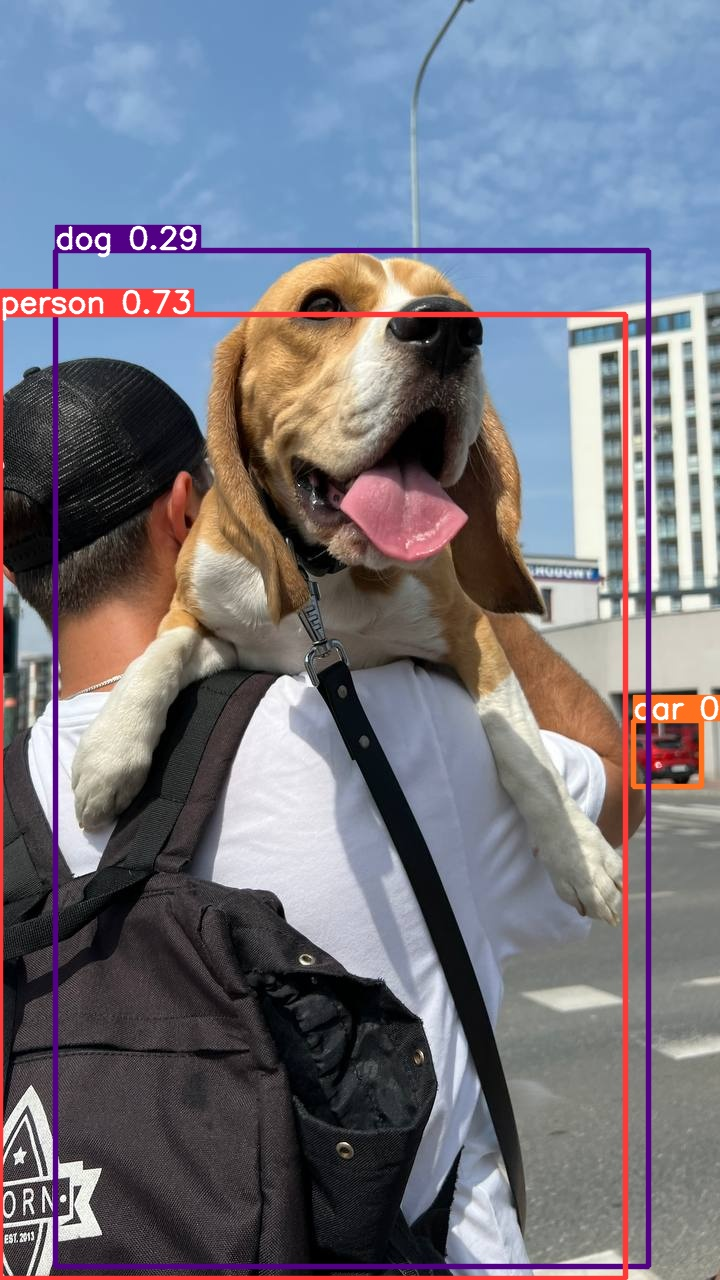

In [ ]:
Image(filename='runs/detect/predict/dog.jpeg', height=600)

## Train YOLOv8 Model on Custom Dataset

In [5]:

dataset_path = '/content/drive/MyDrive/sentry/image_dataset.rar'
bbox_path = '/content/drive/MyDrive/sentry/MPHB_txt'

# Unrar the dataset
!unrar x {dataset_path} "/content/dataset/"

# The dataset is now available in '/content/dataset/' directory
# You will need to process the bounding box files and organize them
# into a format compatible with YOLOv8 training
# (e.g., converting them to YOLO format annotation files)

Streaming output truncated to the last 5000 lines.
Extracting  /content/dataset/Human Body Image/09877.jpg                   81%  OK 
Extracting  /content/dataset/Human Body Image/08212.jpg                   81%  OK 
Extracting  /content/dataset/Human Body Image/19976.jpg                   81%  OK 
Extracting  /content/dataset/Human Body Image/20527.jpg                   81%  OK 
Extracting  /content/dataset/Human Body Image/24372.jpg                   81%  OK 
Extracting  /content/dataset/Human Body Image/11898.jpg                   81%  OK 
Extracting  /content/dataset/Human Body Image/18610.jpg                   81%  OK 
Extracting  /content/dataset/Human Body Image/19844.jpg                   81%  OK 
Extracting  /content/dataset/Human Body Image/15047.jpg                   81%  OK 
Extracting  /content/dataset/Human Body Image/04956.jpg                   81%  OK 
Extracting  /content/dataset/

In [6]:
import os
from PIL import Image

def load_bbox_data(bbox_file_path):
    bbox_data = {}
    with open(bbox_file_path, 'r') as file:
        lines = file.readlines()

    current_idx = None
    for line in lines:
        line = line.strip()
        if line.startswith("idx:"):
            current_idx = line.split()[1].strip()
            bbox_data[current_idx] = []
        elif current_idx and line and not line.startswith("source") and not line.startswith("bbox:"):
            # Process only the lines with numeric data
            bbox_data[current_idx].append(list(map(float, line.split())))
    return bbox_data

def calculate_yolo_format(bbox, image_width, image_height):
    left, top, right, bottom = bbox

    # Calculate Width and Height of the Bounding Box
    bbox_width = right - left
    bbox_height = bottom - top

    # Calculate the Center Coordinates of the Bounding Box
    x_center = left + (bbox_width / 2)
    y_center = top + (bbox_height / 2)

    # Normalize the Coordinates and Dimensions
    x_center_normalized = x_center / image_width
    y_center_normalized = y_center / image_height
    width_normalized = bbox_width / image_width
    height_normalized = bbox_height / image_height

    return f"{x_center_normalized} {y_center_normalized} {width_normalized} {height_normalized}"

def process_images(directory, bbox_data, class_id):
    for idx in bbox_data:
        filename = f"{idx}.jpg"  # Assuming image files are in .jpg format
        image_path = os.path.join(directory, filename)
        if os.path.exists(image_path):
            with Image.open(image_path) as img:
                image_width, image_height = img.size

            yolo_data_lines = []
            for bbox in bbox_data[idx]:
                yolo_data = f"{class_id} {calculate_yolo_format(bbox, image_width, image_height)}"
                yolo_data_lines.append(yolo_data)

            output_txt_path = os.path.join(directory, f"{idx}.txt")
            with open(output_txt_path, 'w') as output_file:
                output_file.write("\n".join(yolo_data_lines))
        else:
            print(f"Image file {filename} not found.")


# Directory containing the images
image_directory = '/content/dataset/Human Body Image'
# Path to the file containing bounding box data
bbox_file_path = '/content/drive/MyDrive/sentry/MPHB_txt/MPHB-label.txt'
# Class ID (assuming it's the same for all images)
class_id = 1

# Load bounding box data
bbox_data = load_bbox_data(bbox_file_path)
# Process images
process_images(image_directory, bbox_data, class_id)


Image file 02317.jpg not found.
Image file 06453.jpg not found.
Image file 08418.jpg not found.
Image file 17858.jpg not found.


In [7]:
import os
import shutil
import math

# Function to move files
def move_files(file_list, source_dir, destination_dir):
    for file_id in file_list:
        image_file = f"{file_id}.jpg"
        annotation_file = f"{file_id}.txt"

        # Move the image file
        image_path = os.path.join(source_dir, image_file)
        annotation_path = os.path.join(source_dir, annotation_file)

        if os.path.isfile(image_path) and os.path.isfile(annotation_path):
            shutil.move(image_path, os.path.join(destination_dir, image_file))
            shutil.move(annotation_path, os.path.join(destination_dir, annotation_file))
            print(f"Moved {image_file} and {annotation_file} to {destination_dir}")
        else:
            if not os.path.isfile(image_path):
                print(f"Image file {image_file} not found in source directory.")
            if not os.path.isfile(annotation_path):
                print(f"Annotation file {annotation_file} not found in source directory.")

# Function to load file IDs
def load_file_ids(txt_file_path):
    with open(txt_file_path, 'r') as file:
        file_ids = [line.strip() for line in file if line.strip().isdigit()]
    return file_ids

# Paths
source_dir = '/content/dataset/DATA'
train_dir = '/content/dataset/train'
test_dir = '/content/dataset/test'
validate_dir = '/content/dataset/validate'

# Create directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(validate_dir, exist_ok=True)

# Load file IDs from the text files
test_file_ids = load_file_ids('/content/drive/MyDrive/sentry/MPHB_txt/test.txt')
trainval_file_ids = load_file_ids('/content/drive/MyDrive/sentry/MPHB_txt/train+val.txt')

# Split the trainval IDs into training and validation
num_train = math.ceil(len(trainval_file_ids) * 0.9)
train_file_ids = trainval_file_ids[:num_train]
validate_file_ids = trainval_file_ids[num_train:]

# Move the files
move_files(test_file_ids, source_dir, test_dir)
move_files(train_file_ids, source_dir, train_dir)
move_files(validate_file_ids, source_dir, validate_dir)


Streaming output truncated to the last 5000 lines.
Moved 19573.jpg and 19573.txt to /content/dataset/train
Moved 19574.jpg and 19574.txt to /content/dataset/train
Moved 19576.jpg and 19576.txt to /content/dataset/train
Moved 19578.jpg and 19578.txt to /content/dataset/train
Moved 19579.jpg and 19579.txt to /content/dataset/train
Moved 19580.jpg and 19580.txt to /content/dataset/train
Moved 19582.jpg and 19582.txt to /content/dataset/train
Moved 19583.jpg and 19583.txt to /content/dataset/train
Moved 19584.jpg and 19584.txt to /content/dataset/train
Moved 19585.jpg and 19585.txt to /content/dataset/train
Moved 19586.jpg and 19586.txt to /content/dataset/train
Moved 19589.jpg and 19589.txt to /content/dataset/train
Moved 19590.jpg and 19590.txt to /content/dataset/train
Moved 19591.jpg and 19591.txt to /content/dataset/train
Moved 19593.jpg and 19593.txt to /content/dataset/train
Moved 19594.jpg and 19594.txt to /content/dataset/train
Moved 19596.jpg and 19596.txt to /content/dataset/tra

In [9]:
import glob
import os

# Define the directories
directories = ['/content/dataset/test', '/content/dataset/train', '/content/dataset/validate']

# Function to change the class label from 1 to 0 in annotations
def change_class_in_annotations(directory):
    # List all .txt files in the directory
    txt_files = glob.glob(os.path.join(directory, '*.txt'))

    # Go through each .txt file and change the class from 1 to 0
    for txt_file in txt_files:
        # Read in all lines of the file
        with open(txt_file, 'r') as file:
            lines = file.readlines()

        # Change the class label from 1 to 0
        lines = [line.replace('1', '0', 1) if line.startswith('1') else line for line in lines]

        # Write the modified lines back to the file
        with open(txt_file, 'w') as file:
            file.writelines(lines)

# Apply the function to each directory
for directory in directories:
    change_class_in_annotations(directory)

print("Class labels in annotations changed from 1 to 0.")


Class labels in annotations changed from 1 to 0.


In [10]:
!yolo task=detect mode=train model=yolov8m.pt data=/content/drive/MyDrive/sentry/MPHB_txt/data.yaml epochs=30 imgsz=640

Ultralytics YOLOv8.0.231 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/drive/MyDrive/sentry/MPHB_txt/data.yaml, epochs=30, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show

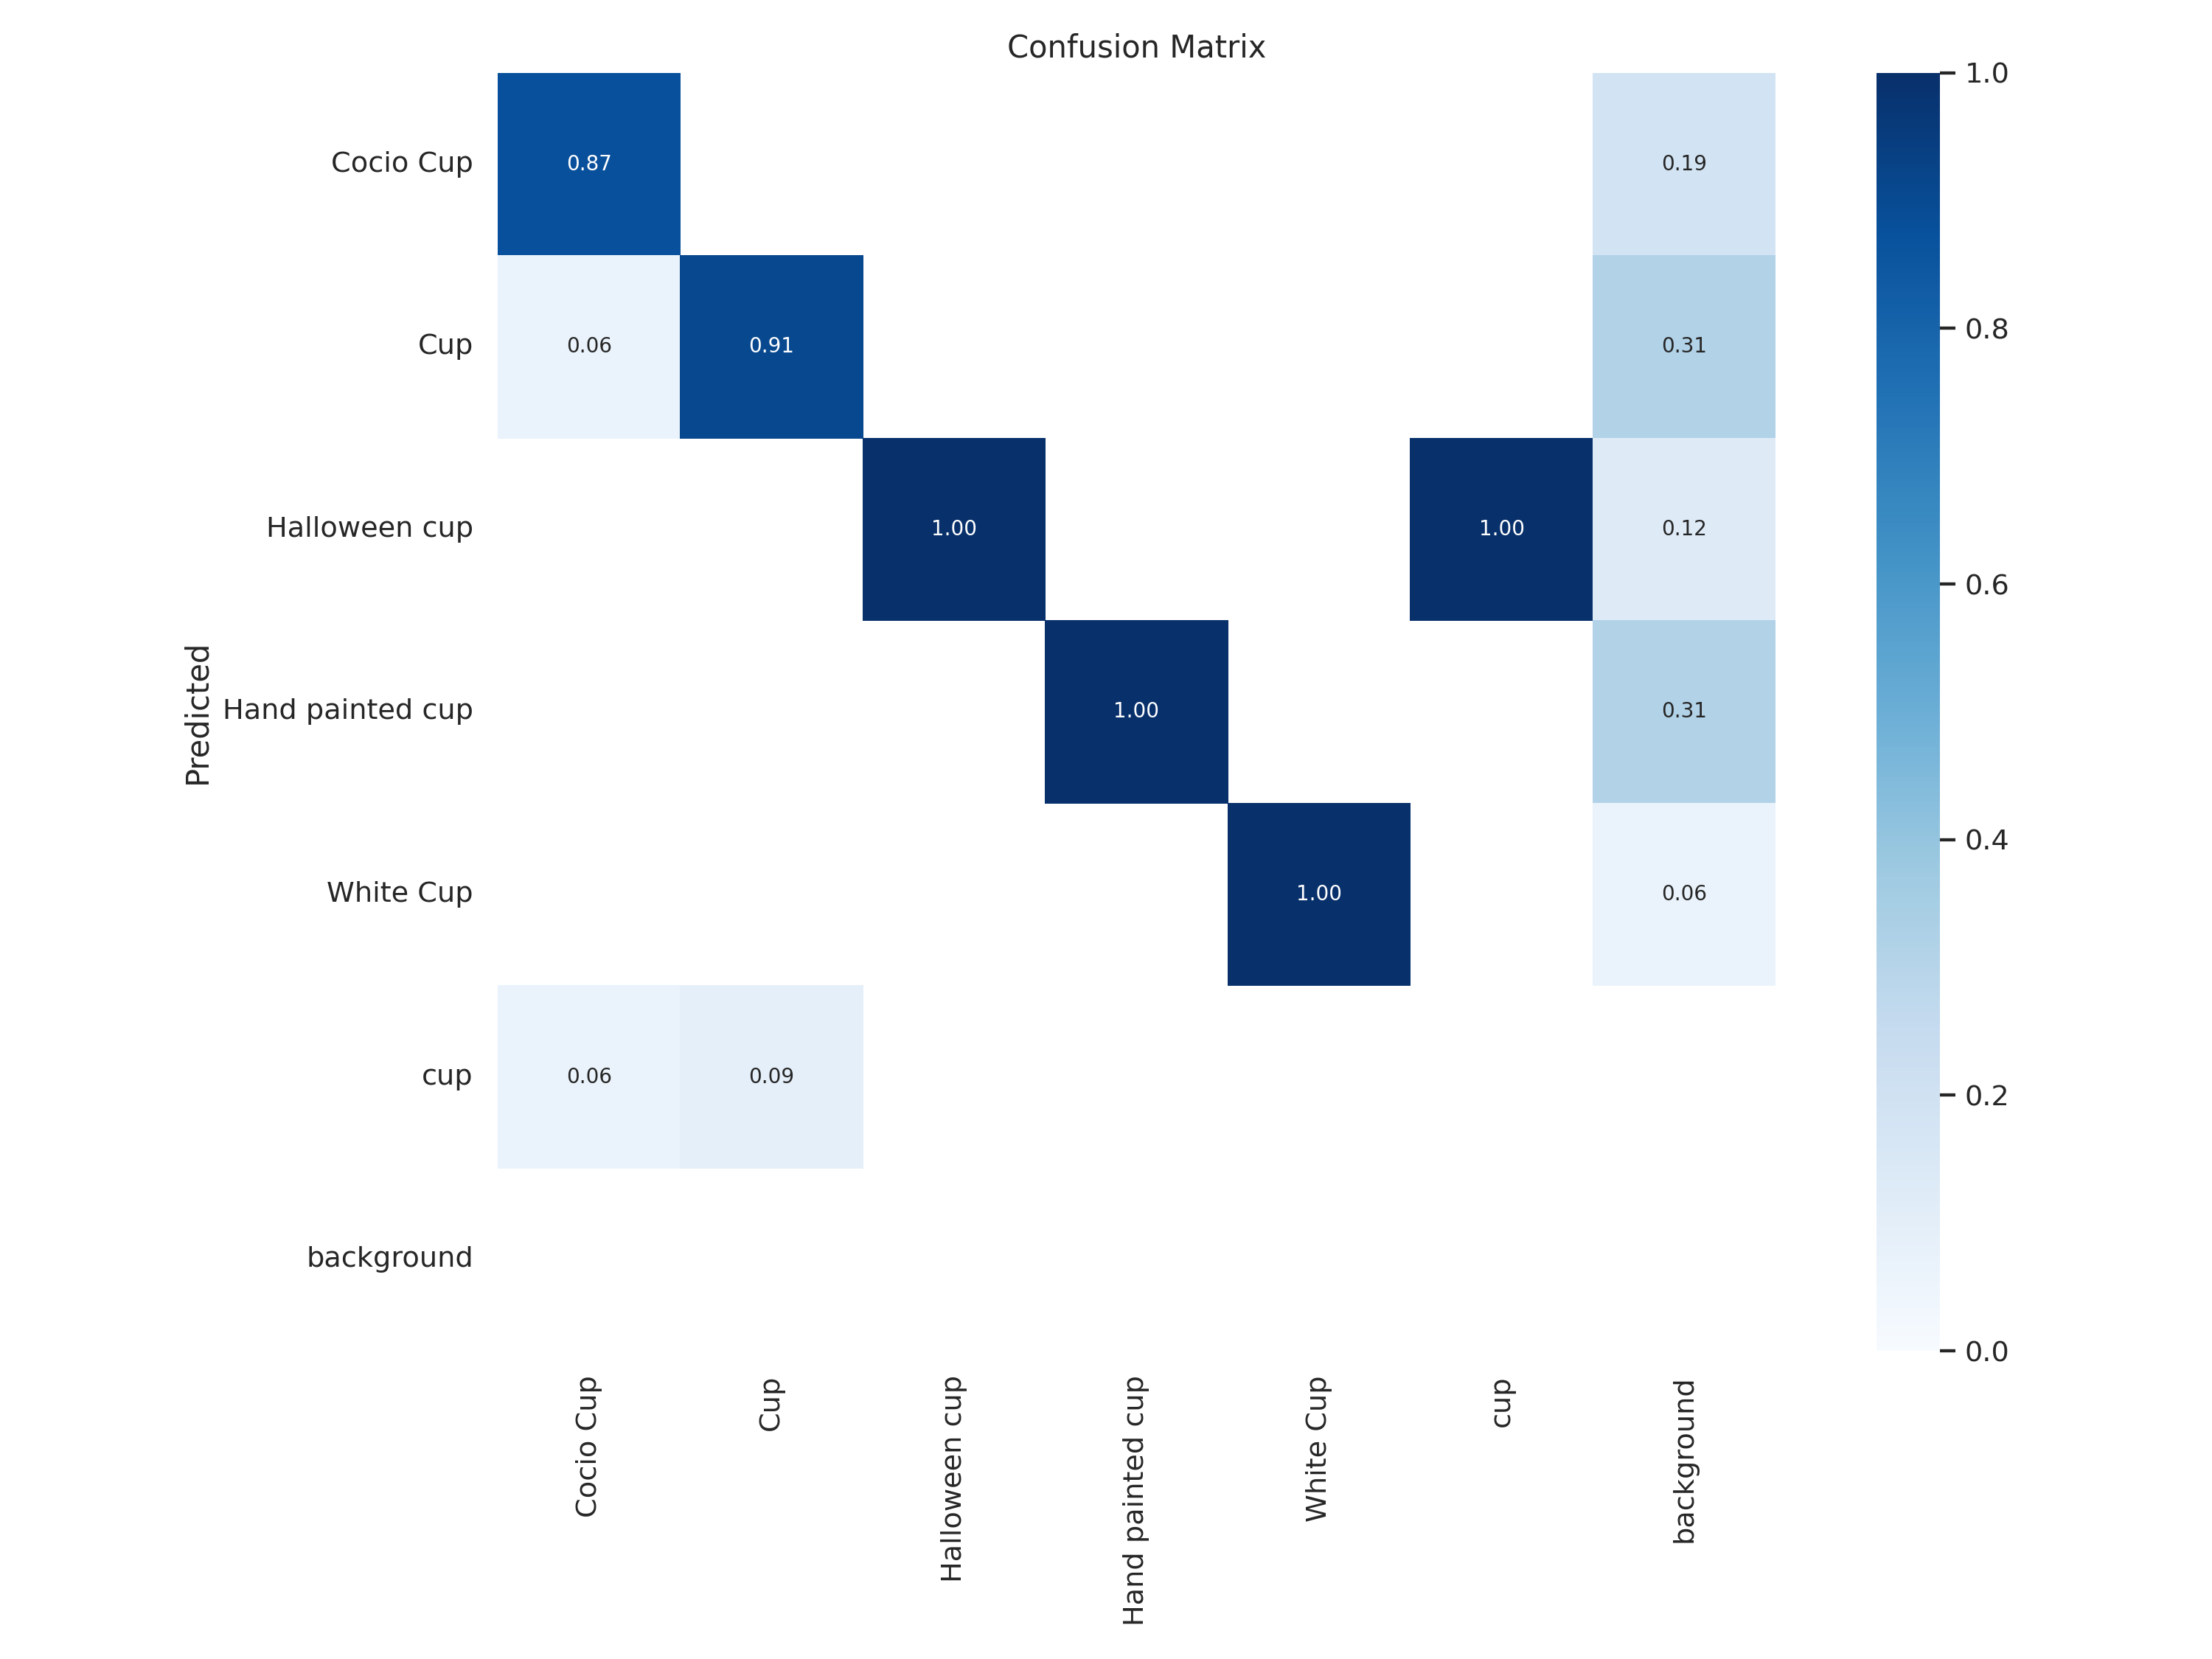

In [ ]:
Image(filename=f'/content/runs/detect/train/confusion_matrix.png', width=600)

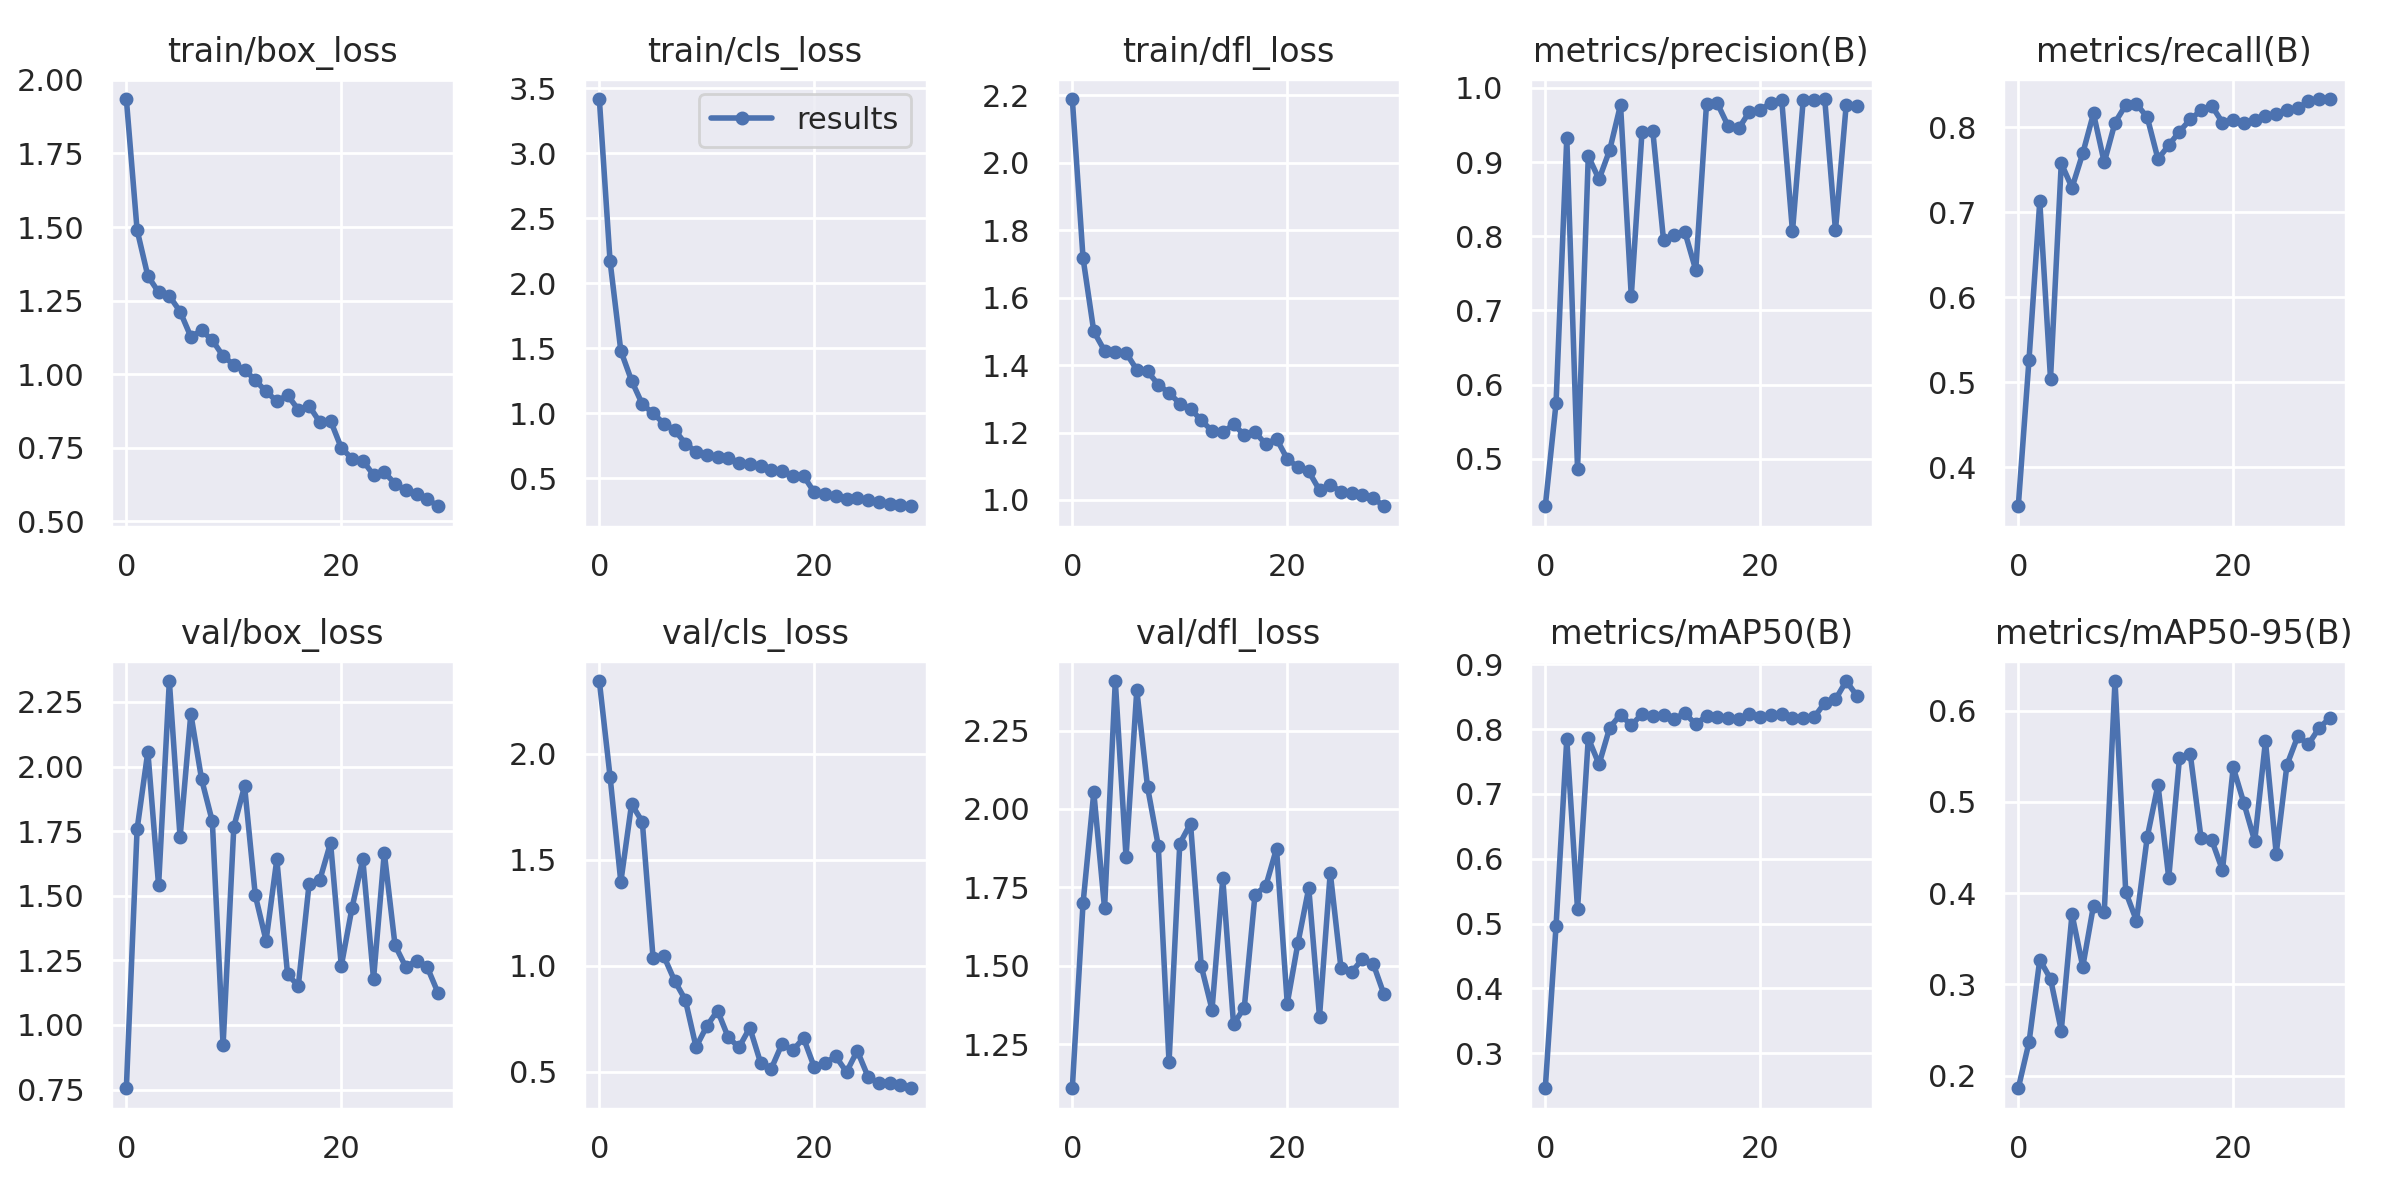

In [ ]:
Image(filename=f'/content/runs/detect/train/results.png', width=600)

In [ ]:
!yolo task=detect mode=val model=/content/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics YOLOv8.0.5 🚀 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)
Fusing layers... 
Model summary: 218 layers, 25843234 parameters, 0 gradients, 78.7 GFLOPs
val: Scanning /content/Cup-Detection-v2-3/valid/labels.cache... 19 images, 0 backgrounds, 0 corrupt: 100% 19/19 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50% 1/2 [00:00<00:00,  1.18it/s]Exception in thread Thread-3:
Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.8/dist-packages/ultralytics/yolo/utils/plotting.py", line 250, in plot_images
    annotator.box_label(box, label, color=color)
  File "/usr/local/lib/python3.8/dist-packages/ultralytics/yolo/utils/plotting.py", line 63, in box_label
    _, _, w, h = self.font.getbbox(label)  # text 

In [ ]:
!yolo task=detect mode=predict model=/content/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images

Ultralytics YOLOv8.0.5 🚀 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)
Fusing layers... 
Model summary: 218 layers, 25843234 parameters, 0 gradients, 78.7 GFLOPs
image 1/10 /content/Cup-Detection-v2-3/test/images/img10_png.rf.1fd0fcc2f6a23a301d61081cc2d4073a.jpg: 640x640 1 Cocio Cup, 1 Cup, 1 Halloween cup, 1 Hand painted cup, 1 White Cup, 38.1ms
image 2/10 /content/Cup-Detection-v2-3/test/images/img1_png.rf.5daff3e408e1fd5975496a089b6d8229.jpg: 640x640 1 Cocio Cup, 1 Cup, 1 Halloween cup, 1 Hand painted cup, 1 White Cup, 38.2ms
image 3/10 /content/Cup-Detection-v2-3/test/images/img34_png.rf.bda5b0247fd2b04401cd4bf31084c623.jpg: 640x640 1 Cup, 1 Halloween cup, 1 Hand painted cup, 1 White Cup, 38.1ms
image 4/10 /content/Cup-Detection-v2-3/test/images/img43_png.rf.7760ddd4d75dc1bdda41cefd09cd3ffb.jpg: 640x640 1 Cocio Cup, 2 Cups, 1 Halloween cup, 2 Hand painted cups, 1 White Cup, 36.1ms
image 5/10 /content/Cup-Detection-v2-3/test/images/img59_png.rf.5fd0f9c99e67da7dc735600

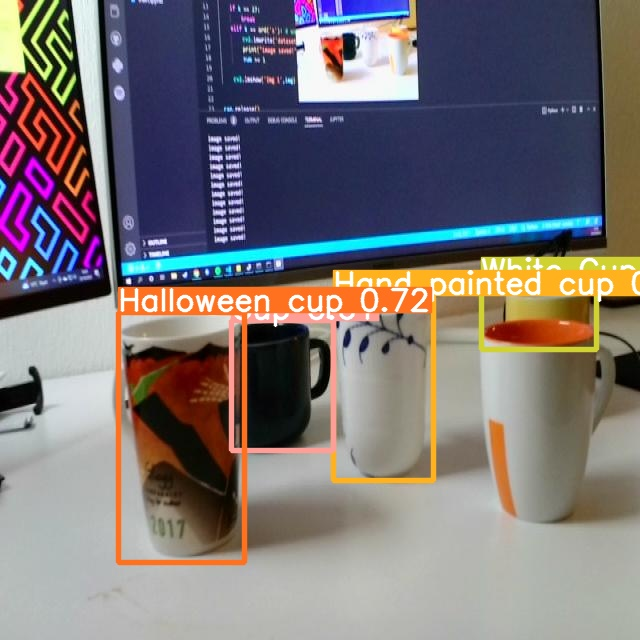

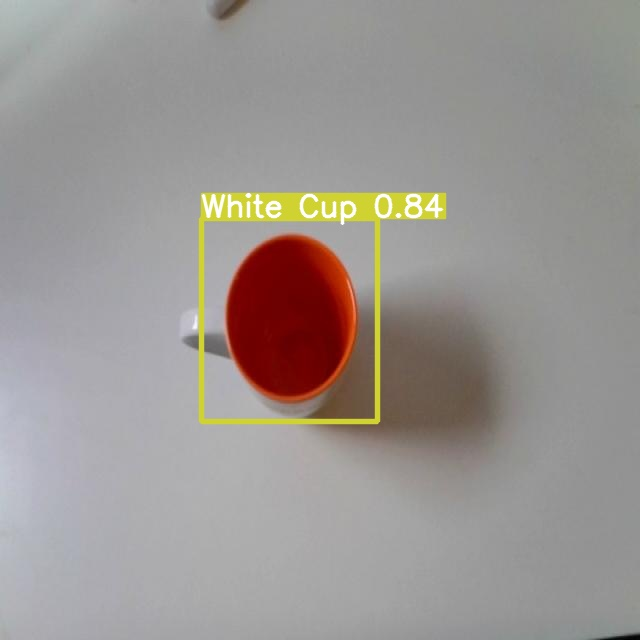

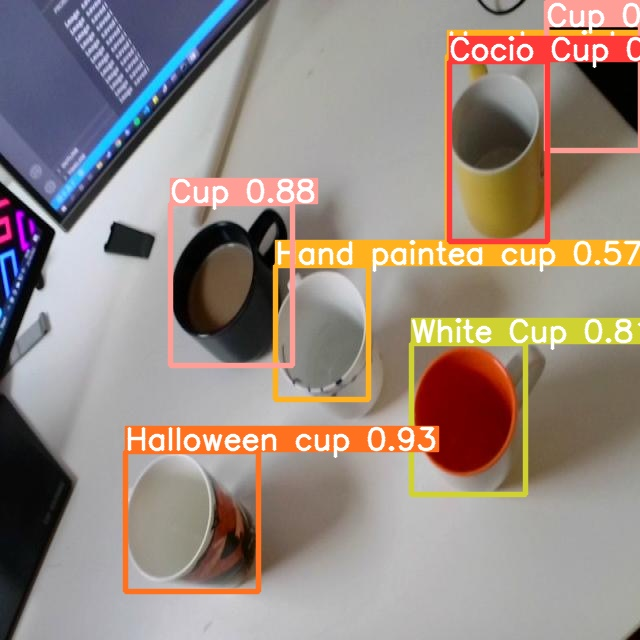

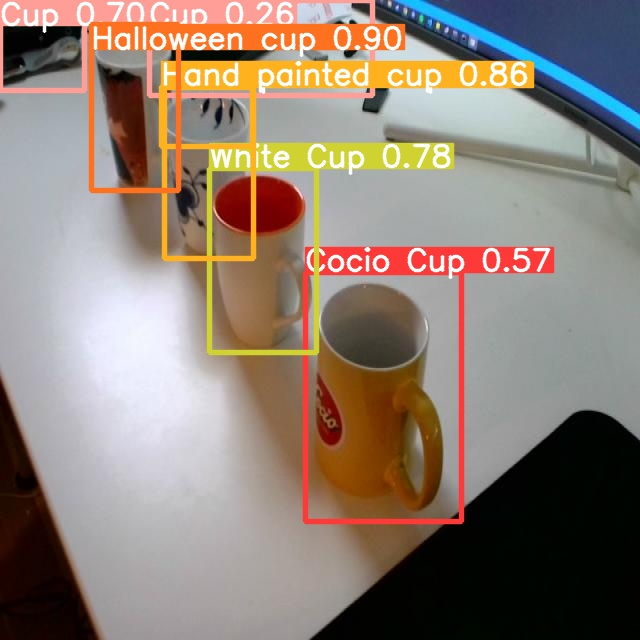

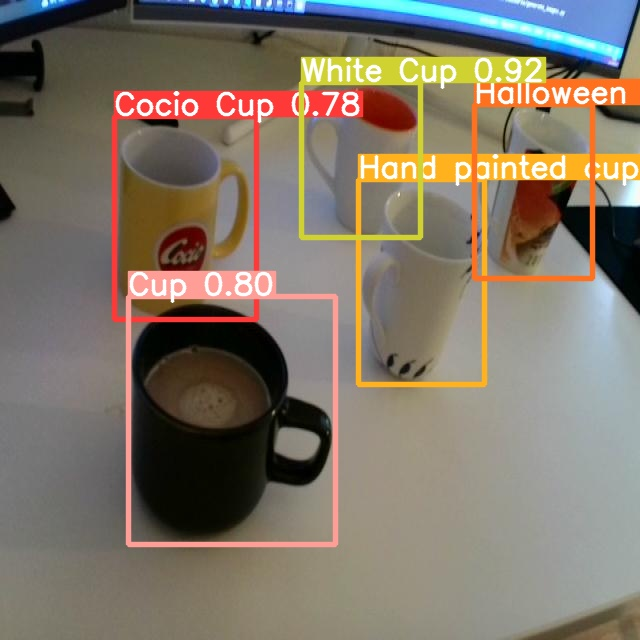

In [ ]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'/content/runs/detect/predict2/*.jpg')[:5]:
      display(Image(filename=image_path, height=600))
      print("\n")